In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

CH2NS = 0.0009765625 # AMANEQ HRTDC time unit to ns

#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master("local[10]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
spark._jvm.decoders.HRTDCDecoder.registerUDF(spark._jsparkSession)

df = spark.read.parquet("parquet/run0030.parquet")

df_dc = df.filter("femType==5 and (femId==616 or femId==617 or femId==618)").select("femId","data").withColumn("decoded",F.expr("decode_hrtdc_segdata(data)"))
df_dc = df_dc.select("femId","decoded.*").select("femId","hbf.*","data").select("femId","hbfNumber","data").filter("array_size(decoded.data)>0")
df_dc = df_dc.withColumn("ex",F.explode("data")).select("femId","hbfNumber","ex.*")
df_dc = df_dc.withColumn("rand",F.rand().cast("float")).withColumn("tcal", (F.col("time").cast("float") + F.col("rand"))*F.lit(CH2NS).cast("float")).drop("time").drop("rand")
df_dc = df_dc.withColumn("rand",F.rand().cast("float")).withColumn("charge", (F.col("tot").cast("float") + F.col("rand"))*F.lit(CH2NS).cast("float")).drop("tot").drop("rand")
df_dc.show(1)

# Map dc31 and dc32
df_map31 = spark.read.csv("map/dc31_map.csv",inferSchema=True,header=True).withColumn("id",F.col("id").cast("int")).withColumn("femId",F.col("femId").cast("int")).withColumn("ch",F.col("ch").cast("int"))
df_dc31 = df_dc.join(df_map31,on=["ch","femId"]).drop("ch").drop("femId")
df_map32 = spark.read.csv("map/dc32_map.csv",inferSchema=True,header=True).withColumn("id",F.col("id").cast("int")).withColumn("femId",F.col("femId").cast("int")).withColumn("ch",F.col("ch").cast("int"))
df_dc32 = df_dc.join(df_map32,on=["ch","femId"]).drop("ch").drop("femId")

df_dc31.show(5)
df_dc32.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/13 14:58:13 WARN Utils: Your hostname, gpuana02, resolves to a loopback address: 127.0.1.1; using 192.168.1.216 instead (on interface enp4s0)
26/01/13 14:58:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/13 14:58:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/13 14:58:14 WARN RapidsPluginUtils: RAPIDS Accelerator 25.10.0 using cudf 25.10.0, private revision 28e7c65b3c0526baba384d9b97ee12e4d6766d9a
26/01/13 14:58:14 WARN RapidsPluginUtils: RAPIDS Accelerator is enabled, to disable GPU support set `spark.rapids.sql.enabled` to false.


+-----+---------+---+-------+--------+
|femId|hbfNumber| ch|   tcal|  charge|
+-----+---------+---+-------+--------+
|  618|  4000463| 18|73544.0|89.13566|
+-----+---------+---+-------+--------+
only showing top 1 row
+---------+----+------+---+
|hbfNumber|tcal|charge| id|
+---------+----+------+---+
+---------+----+------+---+

+---------+---------+---------+---+
|hbfNumber|     tcal|   charge| id|
+---------+---------+---------+---+
|  4000463|  73544.0| 89.13566| 35|
|  4000463| 73544.93|84.072945| 34|
|  4000463| 73545.31| 84.11146| 39|
|  4000463| 73546.72| 87.43687| 42|
|  4000463|73546.734| 86.72317| 38|
+---------+---------+---------+---+
only showing top 5 rows


Statistics:
[[    0.     0.     0.]
 [    0. 21888.     0.]
 [    0.     0.     0.]]


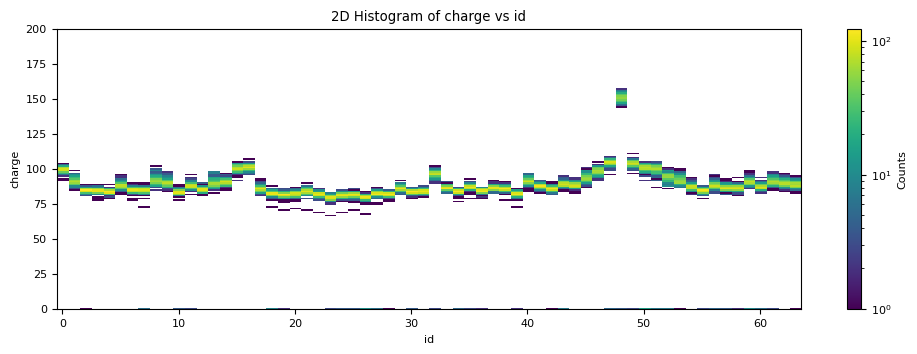

In [3]:
from hist.sparkHist2d import Hist2D
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(0, figsize=(12,8))
plt.rcParams["font.size"] = 8
#plt.subplot2grid((2,1),(0,0))
#h = Hist2D(df_dc31, ["id","charge"], [125,200], [[-0.5, 123.5], [0, 200]], norm=LogNorm(), interpolation='none')
plt.subplot2grid((2,1),(1,0))
h = Hist2D(df_dc32, ["id","charge"], [65,200], [[-0.5, 63.5], [0, 200]], norm=LogNorm(), interpolation='none')
plt.show()